# Rianna's ML models

In [1]:
# import data
import pickle
with open("data_splits.pkl", "rb") as f:
    X_train, X_test, y_train, y_test = pickle.load(f)

## ML Models

### Method: XGBoost

In [19]:
import xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

#### Plotting function

In [3]:
# helper function
import matplotlib.pyplot as plt

def plot_train_val_losses(eval_scores):
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    
    for fold in range(5):
        fold_scores = eval_scores[fold]
        axes[fold].plot(fold_scores['validation_0']['rmse'], label="Train Loss")
        axes[fold].plot(fold_scores['validation_1']['rmse'], label="Validation Loss")
        axes[fold].set_title(f"Fold {fold+1}")
        axes[fold].set_xlabel("Boosting Rounds")
        axes[fold].set_ylabel("RMSE Loss")
        axes[fold].legend()
    
    plt.tight_layout()
    plt.savefig("XGB Regressor Train and Validation RMSE Scores")

In [4]:
def plot_actual_vs_predicted(y_test, y_pred):
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("Actual vs Predicted")
    plt.show()

#### Hyperparameter tuning with RandomizedSearchCV

In [5]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

param_dist = {
    'learning_rate': uniform(0.001, 0.2),
    'max_depth': randint(3, 10),
    'n_estimators': randint(50, 400),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'reg_alpha': [0, 0.1, 0.5], # L1 regularization
    'reg_lambda': [1, 5, 10] # L2 regularization
}

xgb = XGBRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
print("Best hyperparameters found:", best_params)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best hyperparameters found: {'colsample_bytree': np.float64(0.6783931449676581), 'learning_rate': np.float64(0.010045457782107612), 'max_depth': 7, 'n_estimators': 257, 'reg_alpha': 0, 'reg_lambda': 5, 'subsample': np.float64(0.815876852955632)}


#### K-Fold Cross-Validation

Fold 1 — Train MSE: 0.0749
Fold 2 — Train MSE: 0.0787
Fold 3 — Train MSE: 0.0787
Fold 4 — Train MSE: 0.0769
Fold 5 — Train MSE: 0.0802
Average Train MSE: 0.0779 ± 0.0018


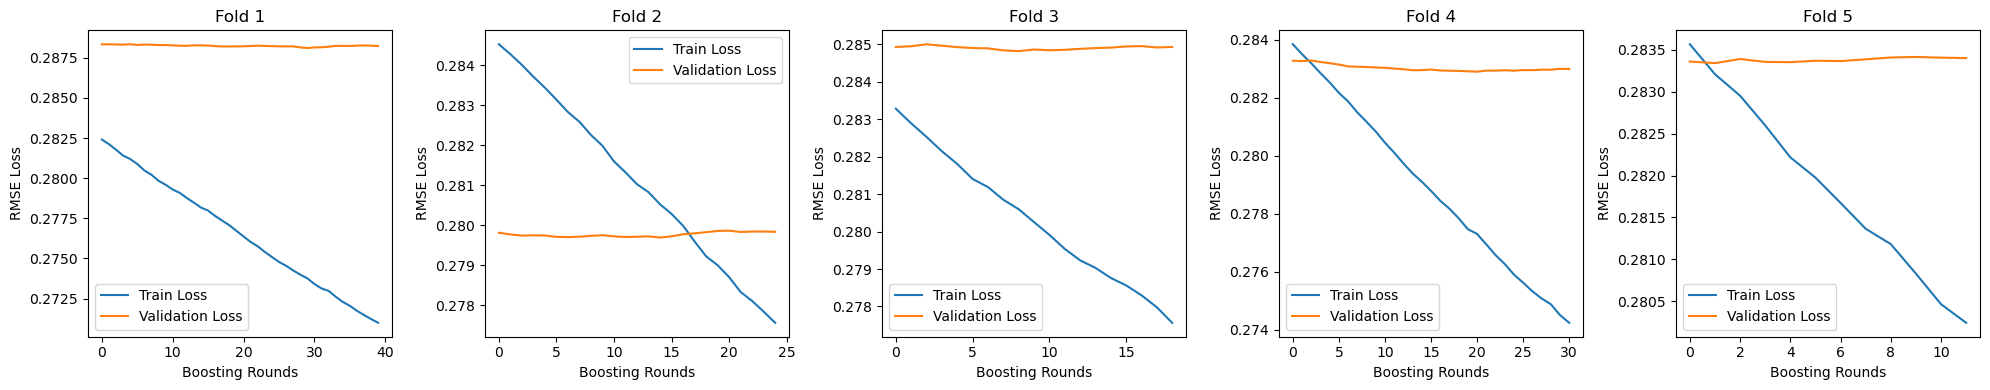

In [13]:
# 5 fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

train_mse_scores = []
eval_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    X_train_in, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_in, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    xgb_model = XGBRegressor(
        **best_params,
        random_state=42,
        eval_metric="rmse",
        early_stopping_rounds=10,
        n_jobs=-1
    )

    xgb_model.fit(
        X_train_in,
        y_train_in,
        eval_set= [(X_train_in, y_train_in), (X_val, y_val)], #[(X_val, y_val)],
        verbose=False,
    )

    evals_result = xgb_model.evals_result()
    eval_scores.append(evals_result)

    y_train_pred = xgb_model.predict(X_train_in)
    train_mse = mean_squared_error(y_train_in, y_train_pred)
    train_mse_scores.append(train_mse)

    print(f"Fold {fold + 1} — Train MSE: {train_mse:.4f}")
    
plot_train_val_losses(eval_scores)

print(f"Average Train MSE: {np.mean(train_mse_scores):.4f} ± {np.std(train_mse_scores):.4f}")

#### Test Results

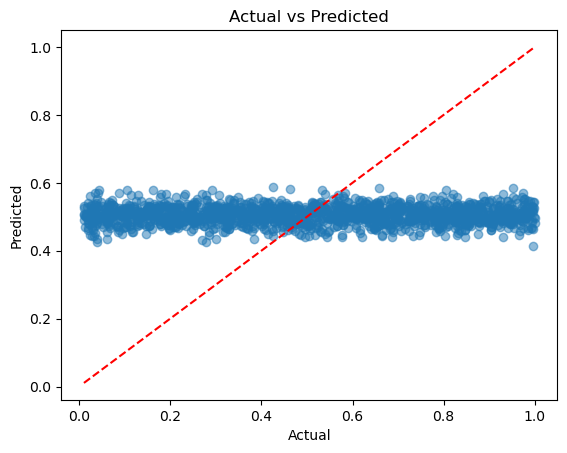

Drug_Response    0.081435
dtype: float64
Final Test MSE: 0.0821
Final Test R²: -0.0080


/Users/riannacampbell/anaconda3/envs/c242/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:4316: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


In [16]:
# remake new model on best params
xgb_model = XGBRegressor(
    **best_params,
    random_state=42,
    eval_metric="rmse",
    n_jobs=-1
)
# xgb_model.early_stopping_rounds = None
xgb_model.fit(X_train, y_train) # Re-fit on all training data
y_test_pred = xgb_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

plot_actual_vs_predicted(y_test, y_test_pred)
print(np.var(y_test))

print(f"Final Test MSE: {test_mse:.4f}")
print(f"Final Test R²: {test_r2:.4f}")

[0.0053252  0.00682565 0.00814959 0.01006777 0.01063894 0.01068466
 0.01101866 0.01295549 0.0124985  0.01410777 0.01593265 0.01332712
 0.01246486 0.0137068  0.01652559 0.01490808 0.01421811 0.01532814
 0.01654296 0.01502173 0.01521742 0.01578274 0.01564675 0.01527279
 0.01661788 0.01584592 0.01750115 0.01685835 0.01725297 0.01641631
 0.01688245 0.01657668 0.01567729 0.01530141 0.01716935 0.01597491
 0.01691762 0.01697441 0.01837971 0.01722741 0.01700572 0.0159841
 0.01855481 0.01691901 0.01672746 0.01561401 0.01741679 0.01560611
 0.01511995 0.01698443 0.01862837 0.01768293 0.01610047 0.01553844
 0.01710723 0.0177624  0.01767974 0.01828284 0.01764701 0.01692515
 0.01724046 0.0192958  0.01548659 0.01414979 0.01479855]


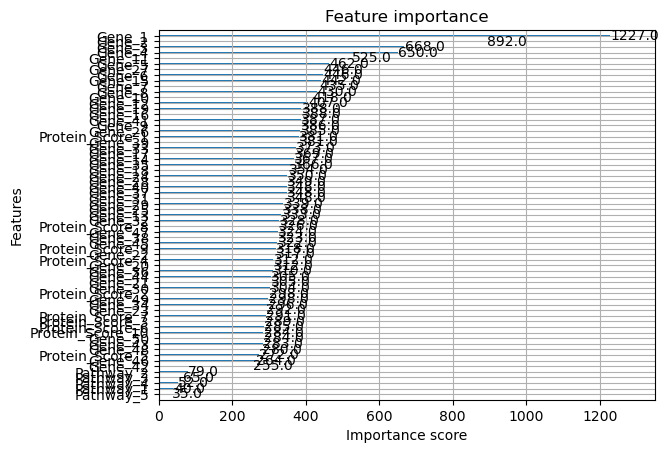

In [21]:
feat_imps = xgb_model.feature_importances_
print(feat_imps)
xgboost.plot_importance(xgb_model)
plt.show()

### Regularization strategies and hyperparameter tuning

In [ ]:
# difference between randomized search CV and manual k-fold CV
# more hyperparam tuning, should be on separate dataset (or nested CV)
# why R2 values so low
# try feature engineering w PCA or other?
# try log scaling?

### Production mode

### Final Results